## Unsupervised Machine Learning

In [2]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

Bad value in file WindowsPath('C:/Users/23898/.matplotlib/stylelib/my_style.mplstyle'), line 34 ('legend.edgecolor : #4100FF'): Key legend.edgecolor: '' does not look like a color arg


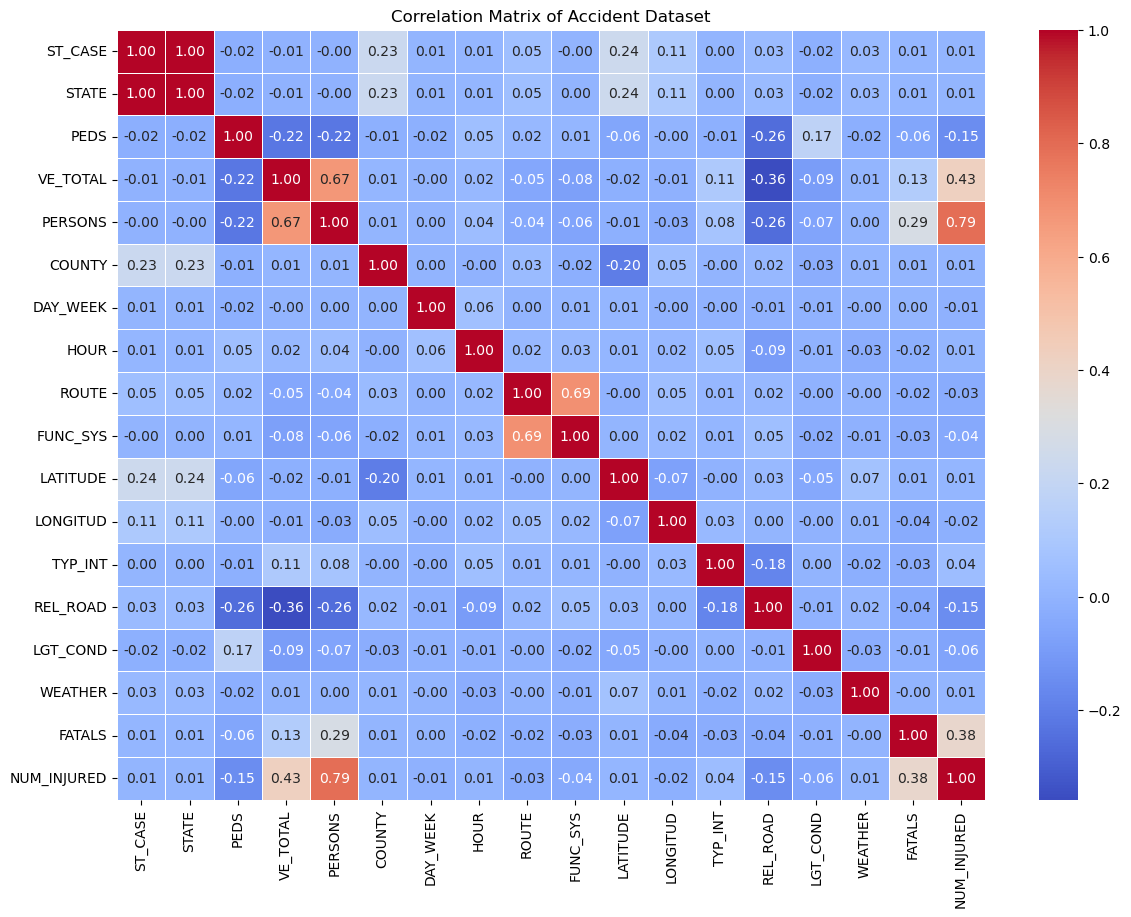

Selected Features Based on Correlation (>0.1): ['PEDS', 'VE_TOTAL', 'PERSONS', 'REL_ROAD', 'FATALS']


In [3]:
# 2. Load the data
df = pd.read_csv('./Processed_data/filtered_accident.csv')

# 3. Separate features and target
X = df.drop(columns=['ST_CASE', 'STATE', 'COUNTY', 'NUM_INJURED'])
y = df['NUM_INJURED']

# 4. Fill missing values
X = X.fillna(0)

# 5. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Correlation matrix and feature selection
# 0.2 Compute correlation matrix (including target NUM_INJURED)
corr = df.corr()

# 0.3 Plot correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Accident Dataset")
plt.show()

# 0.4 Feature selection based on correlation
# Keep features that have at least weak-moderate correlation with NUM_INJURED (>0.1 or <-0.1)
target_corr = corr['NUM_INJURED'].drop('NUM_INJURED')
selected_features = target_corr[(target_corr.abs() > 0.1)].index.tolist()

print(f"Selected Features Based on Correlation (>0.1): {selected_features}")

### Conclusion:
Even the correlation analysis only kept 5 features, we think it is better to keep all variables at this time to make sure the most information can be used.

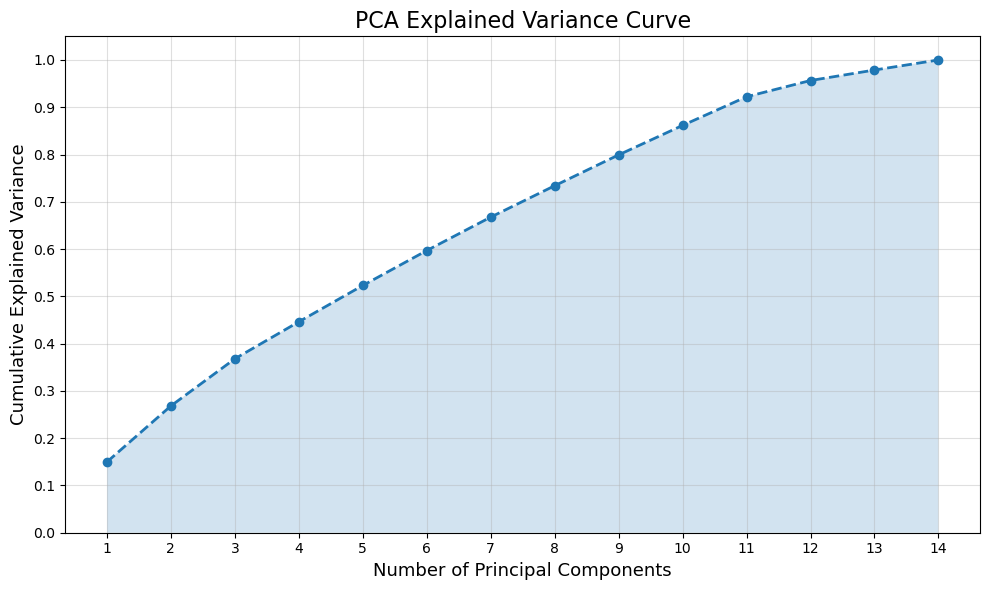

In [10]:
# 6. Apply PCA without fixing number of components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 7. Plot PCA explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10,6))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker='o',
    linestyle='--',
    linewidth=2,
    markersize=6
)

plt.fill_between(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    alpha=0.2
)

plt.xlabel('Number of Principal Components', fontsize=13)
plt.ylabel('Cumulative Explained Variance', fontsize=13)
plt.title('PCA Explained Variance Curve', fontsize=16)
plt.xticks(range(1, len(cumulative_variance) + 1, max(1, len(cumulative_variance)//10)))
plt.yticks(np.linspace(0, 1.0, 11))
plt.grid(alpha=0.4)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

### What does this means:
Our dataset is high-dimensional and complex — PCA isn't able to capture a large proportion of variability in just 2 dimensions.

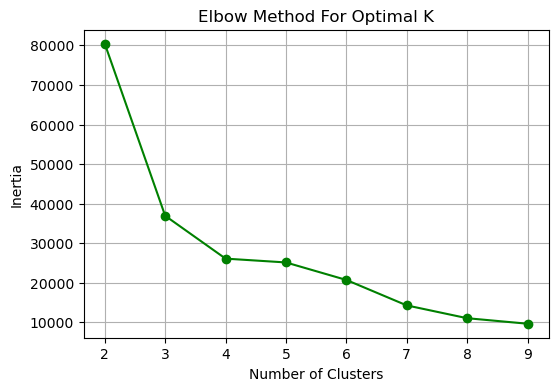

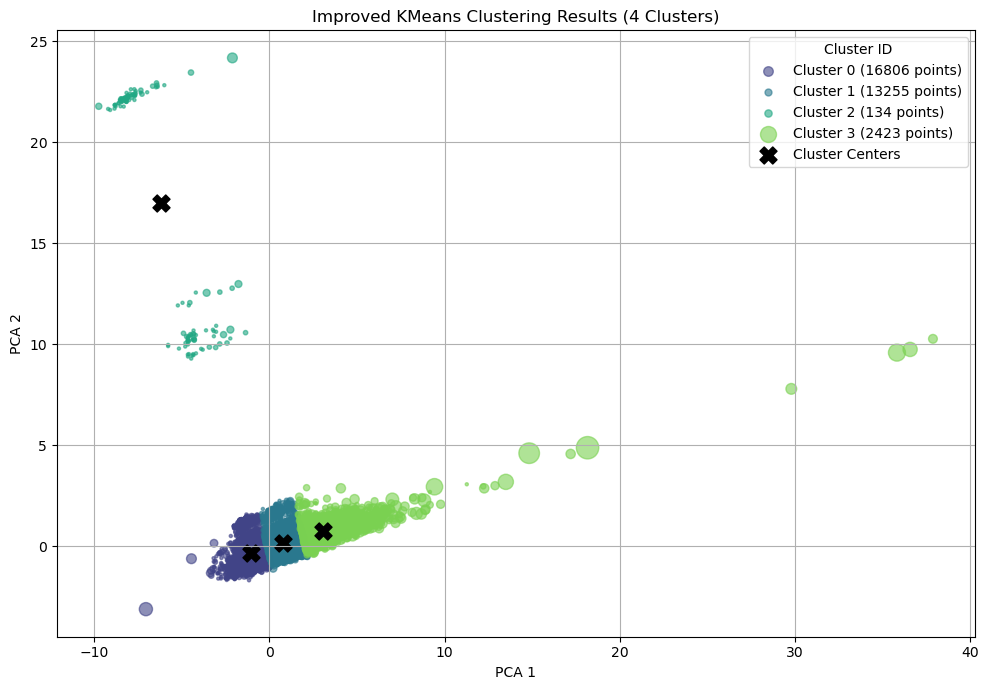

In [5]:
# 8. Find best number of clusters using Elbow Method
inertia = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker='o', color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.grid(True)
plt.show()

# 9. Based on elbow, fit KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# 10. Get cluster centers in PCA space
centers = kmeans.cluster_centers_
unique_labels = np.unique(kmeans_labels)
palette = sns.color_palette("viridis", len(unique_labels))

# Map cluster index to color
colors = [palette[label] for label in kmeans_labels]

sizes = (y - y.min() + 1) * 5  

# Plot
plt.figure(figsize=(10, 7))
for label in unique_labels:
    mask = kmeans_labels == label
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                s=sizes[mask], alpha=0.6,
                color=palette[label], label=f'Cluster {label} ({mask.sum()} points)')

# Plot cluster centers
plt.scatter(centers[:, 0], centers[:, 1],
            c='black', s=150, marker='X', label='Cluster Centers')

plt.title("Improved KMeans Clustering Results (4 Clusters)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster ID', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

### Conclusions:
The elbow plot shows a sharp decrease in inertia as the number of clusters increases from 1 to 3, indicating that adding more clusters significantly improves clustering quality up to this point. The “elbow” point, where the rate of decrease in inertia slows down, is observed at k = 3. Therefore, the optimal number of clusters for your dataset is likely 3, as this provides a good balance between cluster compactness and separation, minimizing within-cluster variance effectively.

### Conclusions: 
the PCA scatter plot showed that the K-Means clustering algorithm has effectively grouped the data into 4 distinct clusters. The clusters are well-separated, indicating that the algorithm has identified meaningful patterns in the data.

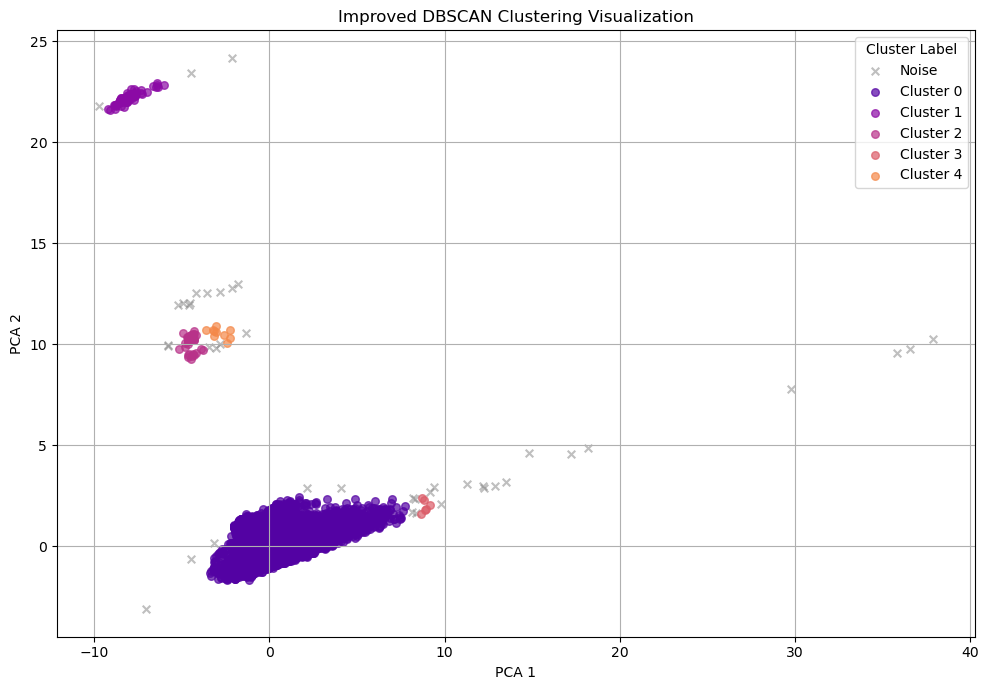

In [6]:
# 11. Fit DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)

# 12. Assign colors to better visualize clusters
unique_labels = np.unique(dbscan_labels)
palette = sns.color_palette("plasma", len(unique_labels))
colors = [palette[label] if label != -1 else (0.2, 0.2, 0.2) for label in dbscan_labels]  

# Plot
plt.figure(figsize=(10, 7))

# Plot non-noise
for label in unique_labels:
    mask = dbscan_labels == label
    if label == -1:
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                    c='gray', s=30, label='Noise', alpha=0.5, marker='x')
    else:
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                    color=palette[label], s=30, label=f'Cluster {label}', alpha=0.7)

plt.title("Improved DBSCAN Clustering Visualization")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster Label")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\23898\AppData\Local\Temp\ipykernel_92504\3669605996.py:34: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(mean, width, height, theta, edgecolor=palette[i],


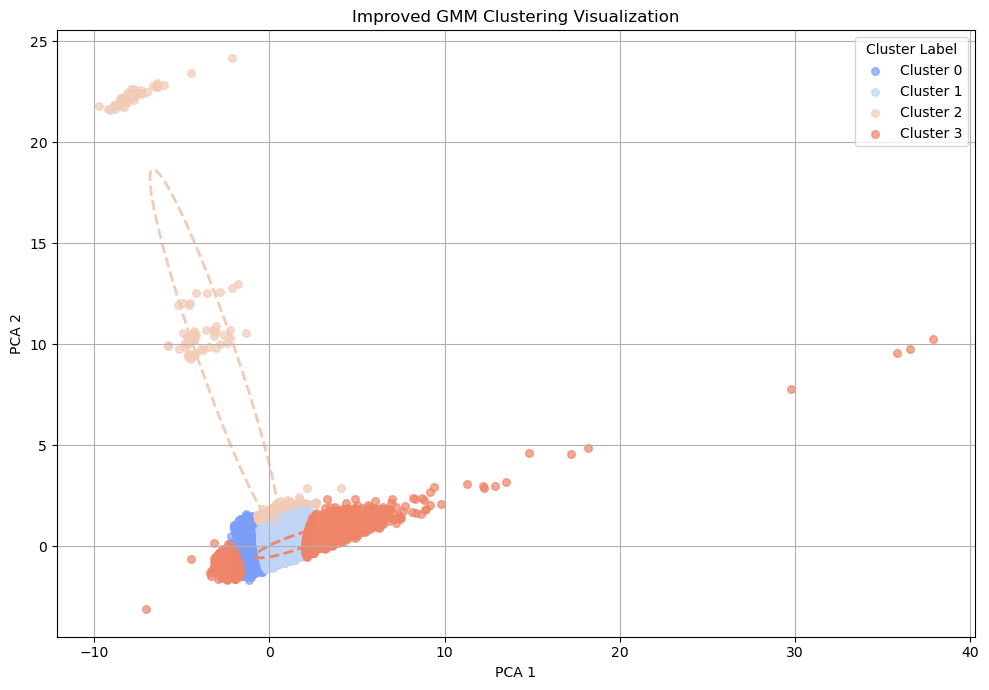

In [7]:
# 13. Fit GMM
from matplotlib.patches import Ellipse

gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(X_pca)

# 14. Use seaborn color palette for clarity
unique_labels = np.unique(gmm_labels)
palette = sns.color_palette("coolwarm", len(unique_labels))

# Plot points by cluster
plt.figure(figsize=(10, 7))
for label in unique_labels:
    mask = gmm_labels == label
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                color=palette[label], s=30, alpha=0.7, label=f"Cluster {label}")

# Optionally draw ellipses for GMM means + covariances
means = gmm.means_
covariances = gmm.covariances_

for i in range(gmm.n_components):
    mean = means[i]
    cov = covariances[i]
    
    # Convert to 2D ellipse if full covariance provided
    if cov.shape == (2, 2):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        width, height = 2 * np.sqrt(vals)
        ellipse = Ellipse(mean, width, height, theta, edgecolor=palette[i],
                          facecolor='none', lw=2, linestyle='--')
        plt.gca().add_patch(ellipse)

plt.title("Improved GMM Clustering Visualization")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster Label")
plt.grid(True)
plt.tight_layout()
plt.show()

KMeans Silhouette Score: 0.5598
DBSCAN Silhouette Score: 0.8034
GMM Silhouette Score: 0.5238


c:\Users\23898\anaconda\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


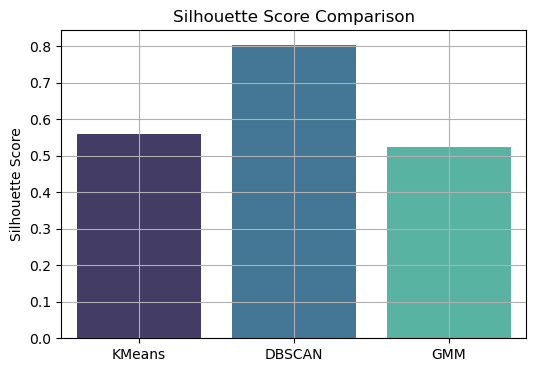

In [8]:
# 15. Compute silhouette scores
kmeans_silhouette = silhouette_score(X_pca, kmeans_labels)
dbscan_silhouette = silhouette_score(X_pca, dbscan_labels)
gmm_silhouette = silhouette_score(X_pca, gmm_labels)

print(f"KMeans Silhouette Score: {kmeans_silhouette:.4f}")
print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.4f}")
print(f"GMM Silhouette Score: {gmm_silhouette:.4f}")

# 16. Plot silhouette scores
scores = [kmeans_silhouette, dbscan_silhouette, gmm_silhouette]
methods = ['KMeans', 'DBSCAN', 'GMM']

plt.figure(figsize=(6,4))
sns.barplot(x=methods, y=scores, palette='mako')
plt.title('Silhouette Score Comparison')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

### Conclusions: 
A Silhouette Score of approximately 0.8 suggests satisfying clustering quality. The value indicates that the data tends to be close to their centroid then to the cluster boundary, suggesting that the data points are relatively well-clustered but there is still room for improvement.

Random Forest MSE: 0.0815
Random Forest R2 Score: 0.9551


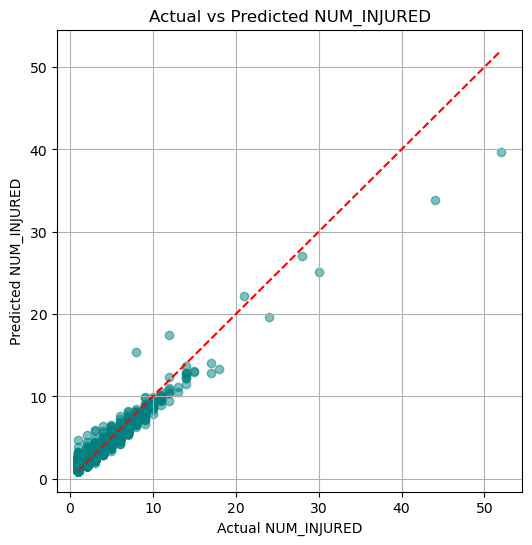

In [9]:
# 17. Add cluster labels as new features
X_new = pd.DataFrame(X_scaled, columns=X.columns)
X_new['KMeans_Cluster'] = kmeans_labels
X_new['DBSCAN_Cluster'] = dbscan_labels
X_new['GMM_Cluster'] = gmm_labels

# 18. Train a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_new, y)
y_pred = rf.predict(X_new)

# 19. Evaluate model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Random Forest MSE: {mse:.4f}")
print(f"Random Forest R2 Score: {r2:.4f}")

# 20. Scatter plot of true vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y, y_pred, alpha=0.5, color='teal')
plt.xlabel('Actual NUM_INJURED')
plt.ylabel('Predicted NUM_INJURED')
plt.title('Actual vs Predicted NUM_INJURED')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.grid(True)
plt.show()